In [2]:
import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse

In [3]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [4]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [02:20, 1426.18it/s]


#  Домашнее задание по NLP # 1 [100 баллов]
## Классификация по тональности 

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5. 

Тексты хранятся в json-ах в массиве responses.

Посмотрим на пример отзыва:

In [5]:
responses[12]

{'city': 'г. Таганрог (Ростовская обл.)',
 'rating_not_checked': False,
 'title': 'Благодарность',
 'num_comments': 2,
 'bank_license': 'лицензия № 2268',
 'author': 'MAN2009',
 'bank_name': 'МТС Банк',
 'datetime': '2015-06-05 12:59:46',
 'text': 'Разбавлю негативные отзывы ложкой меда.   Благодарен Банку за постоянно работающий единственный в городе круглосуточный банкомат с функцией cash-in, входящий в ОРС. Несмотря на отсутствие филиала/ККО в городе.  Пожелания: придумайте какой-нибудь козырек/навес для тени, потому что в солнечную погоду, а тем более летом, экран засвечивается. Приходится стоять вплотную, что затрудняет поиск нужной кнопки.',
 'rating_grade': None}

## Часть 1. Анализ текстов [40/100]

1. Посчитайте количество отзывов в разных городах и на разные банки
2. Постройте гистограмы длин слов в символах и в словах
3. Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм 
* существительных
4. Постройте кривые Ципфа и Хипса
5. Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?
6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

### 1.Посчитайте количество отзывов в разных городах и на разные банки

In [141]:
data = pd.DataFrame(responses)

In [142]:
data.head(1)

,author,bank_license,bank_name,city,datetime,num_comments,rating_grade,rating_not_checked,text,title
0,uhnov1,лицензия № 2562,Бинбанк,г. Москва,2015-06-08 12:50:54,0,NaN,False,Добрый день! Я не являюсь клиентом банка и пор...,Жалоба


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 10 columns):
author                153479 non-null object
bank_license          153498 non-null object
bank_name             153499 non-null object
city                  138325 non-null object
datetime              153499 non-null object
num_comments          153499 non-null int64
rating_grade          88658 non-null float64
rating_not_checked    153499 non-null bool
text                  153499 non-null object
title                 153499 non-null object
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 10.7+ MB


In [ ]:
# delete empty rows for "city"

In [143]:
data.dropna(subset=['city'],inplace = True)

In [144]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138325 entries, 0 to 138946
Data columns (total 10 columns):
author                138324 non-null object
bank_license          138324 non-null object
bank_name             138325 non-null object
city                  138325 non-null object
datetime              138325 non-null object
num_comments          138325 non-null int64
rating_grade          74710 non-null float64
rating_not_checked    138325 non-null bool
text                  138325 non-null object
title                 138325 non-null object
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 10.7+ MB


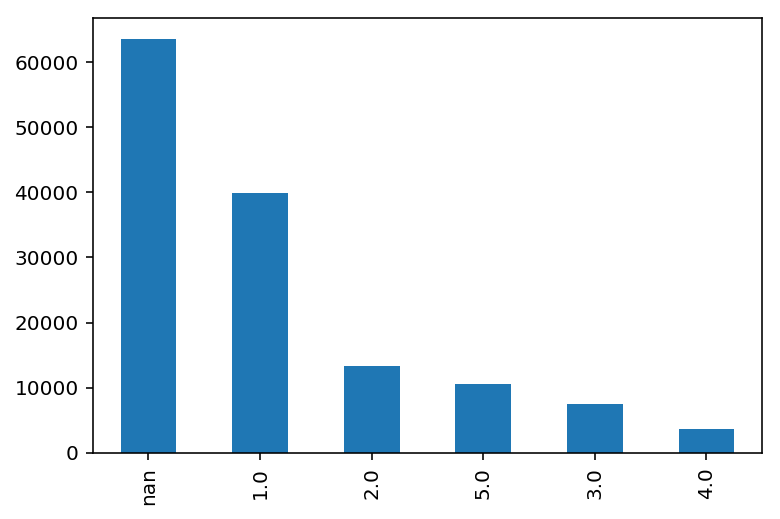

In [9]:
data.rating_grade.value_counts(dropna = False).plot(kind = 'bar')

In [145]:
# deal with nan
data['rating_grade'] = data.rating_grade.fillna('NONE')

In [146]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138323 entries, 0 to 138946
Data columns (total 10 columns):
author                138323 non-null object
bank_license          138323 non-null object
bank_name             138323 non-null object
city                  138323 non-null object
datetime              138323 non-null object
num_comments          138323 non-null int64
rating_grade          138323 non-null object
rating_not_checked    138323 non-null bool
text                  138323 non-null object
title                 138323 non-null object
dtypes: bool(1), int64(1), object(8)
memory usage: 10.7+ MB


In [147]:
# remove rows with 1 name city
len(data.city.value_counts()[data.city.value_counts()<=1])

4029

In [148]:
city_to_delete = data.city.value_counts()[data.city.value_counts()<=1].index.tolist()

In [149]:
data.drop(data.loc[data['city'].isin(city_to_delete)].index,inplace=True)

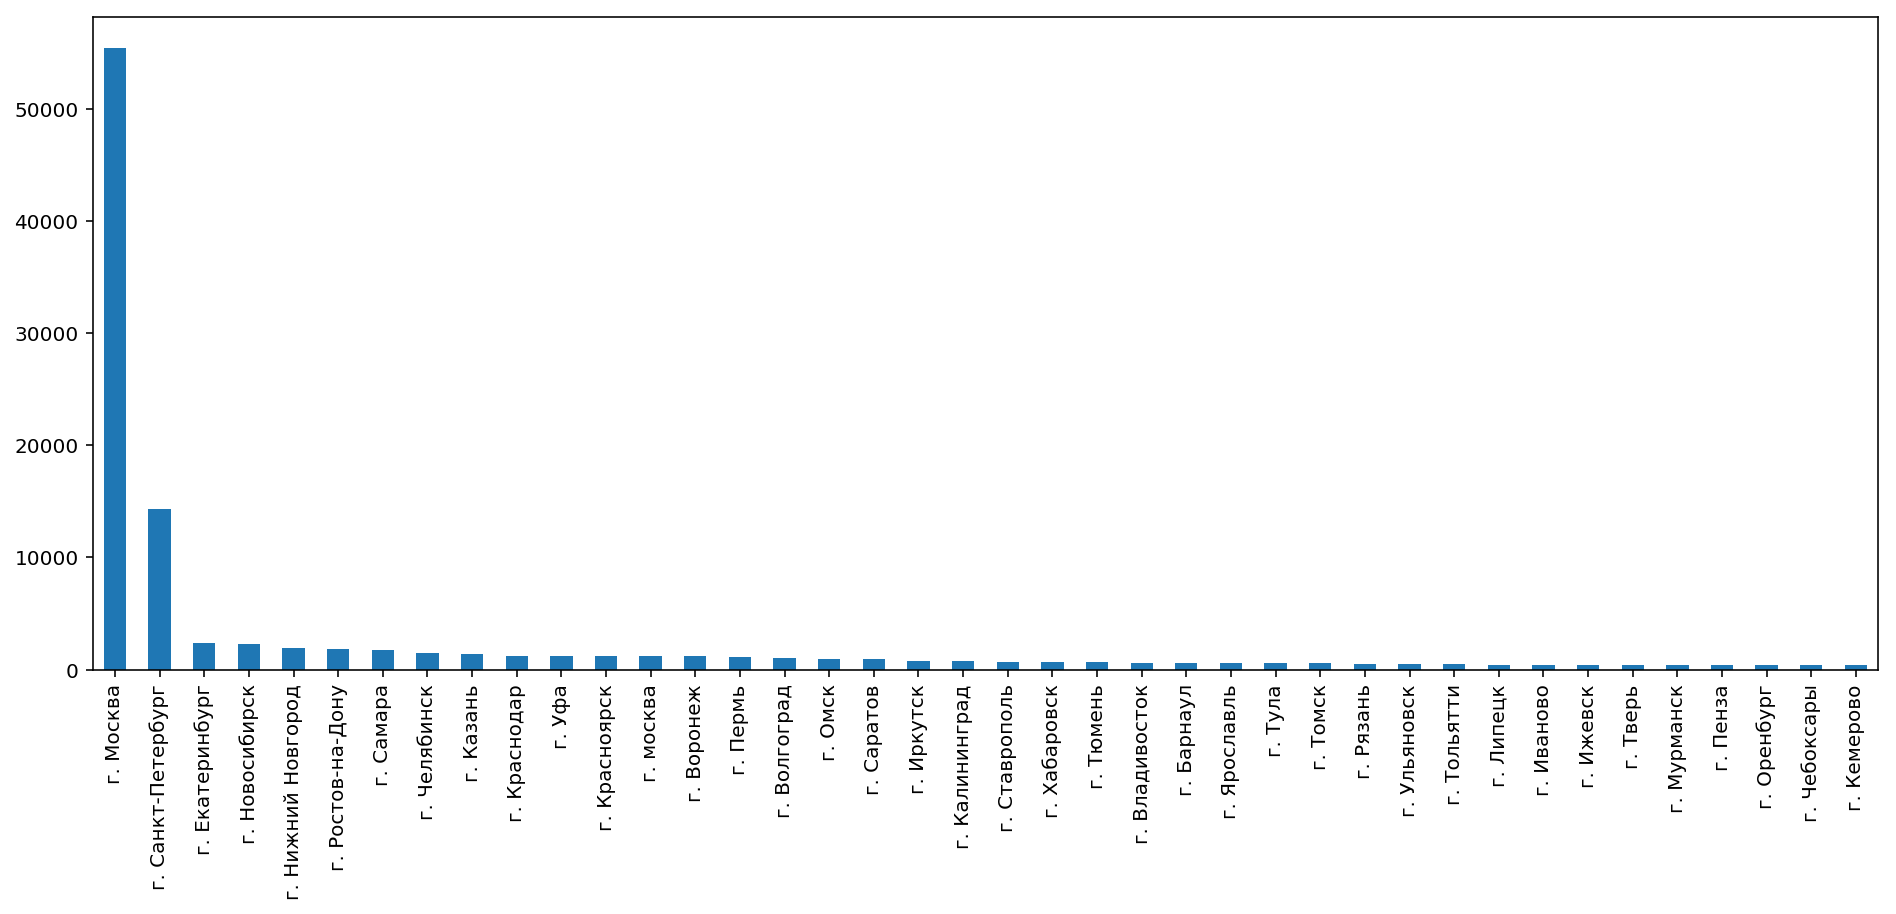

In [15]:
# распределение количества отзывов по городам (top 40)
plt.figure(figsize=(16,6))
data['city'].value_counts()[:40].plot(kind = 'bar')
plt.show()

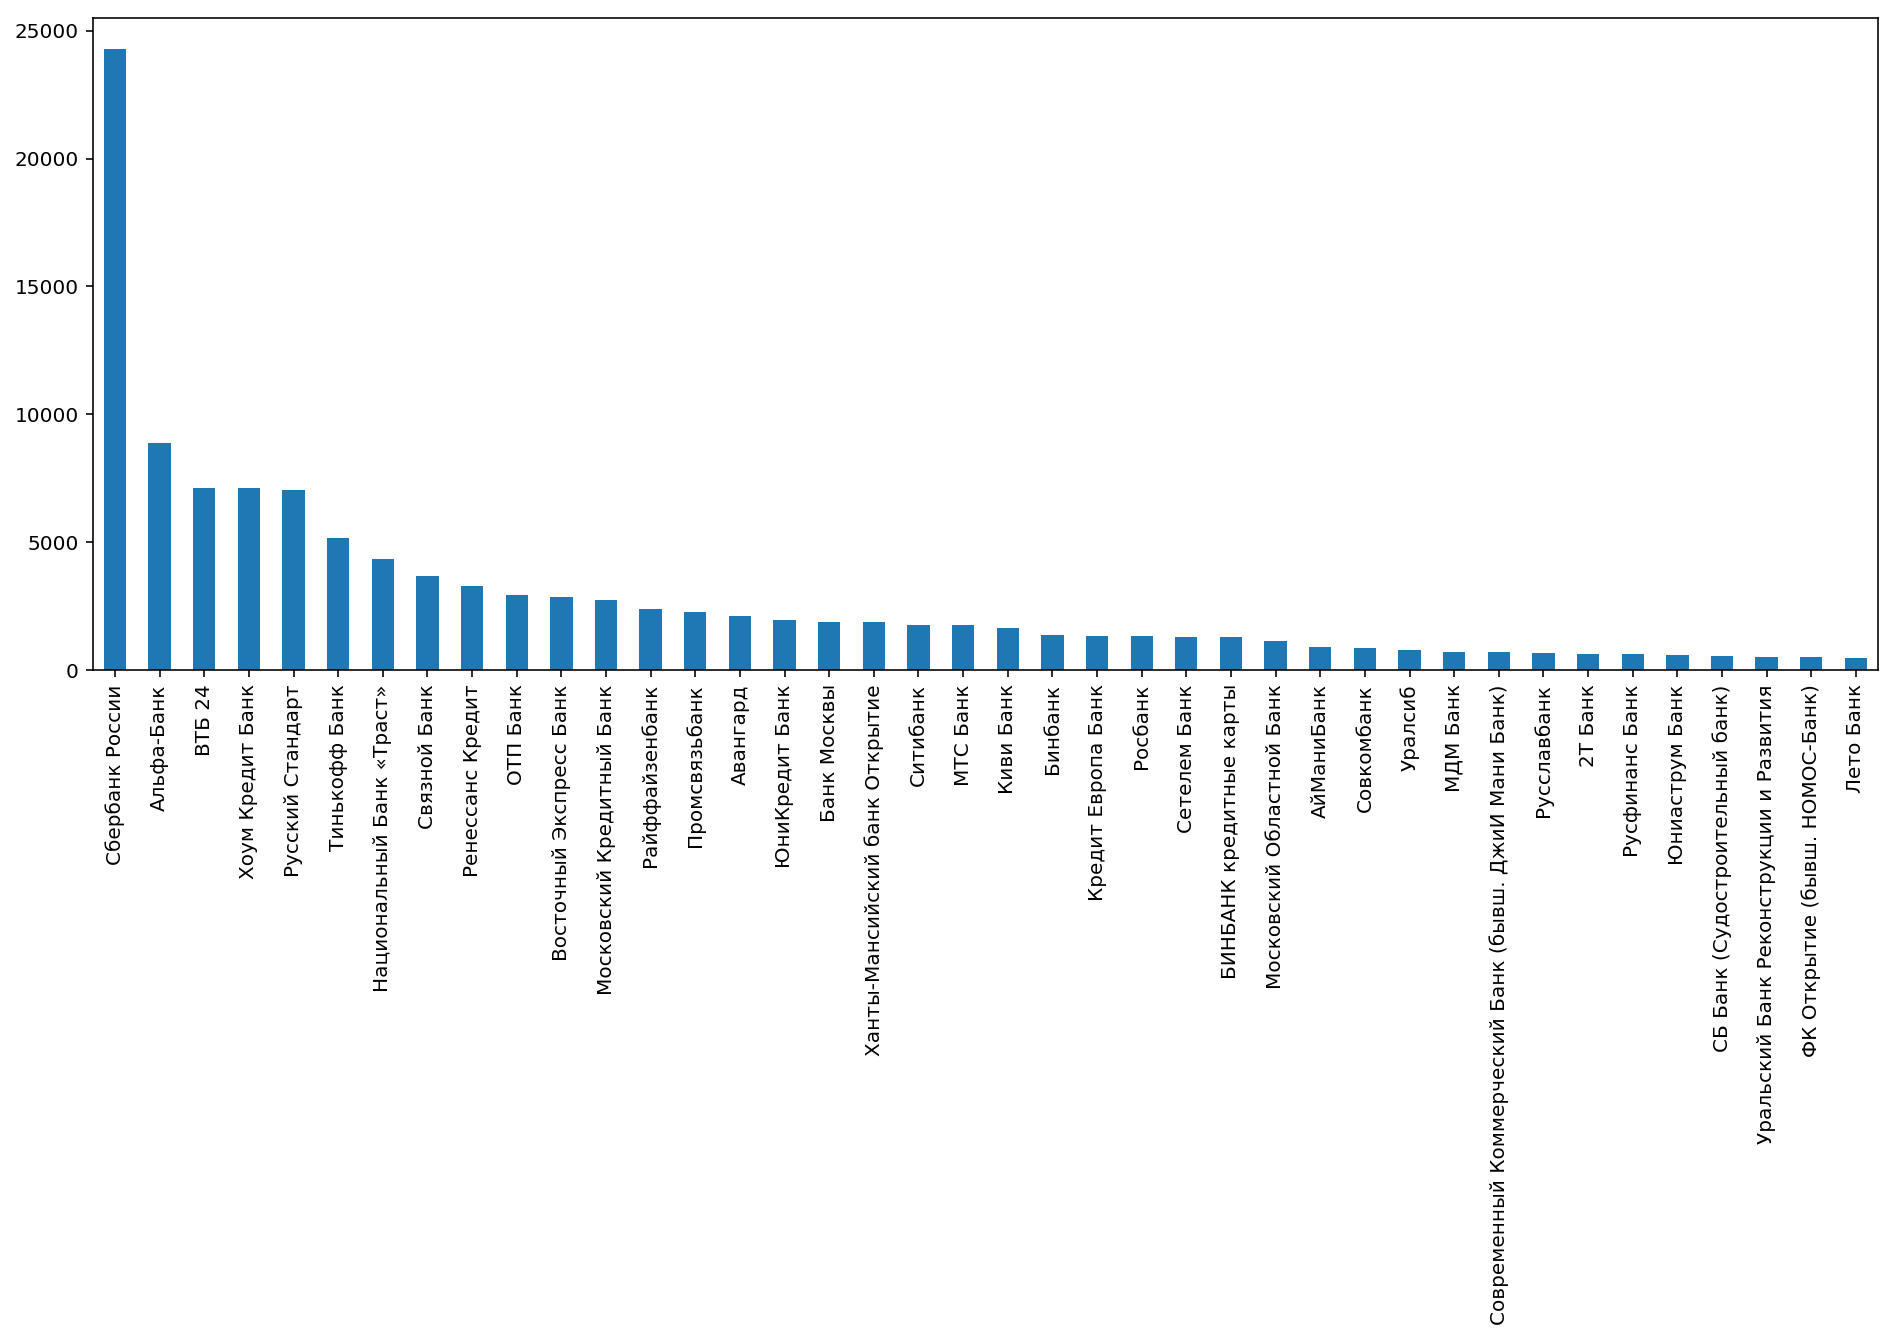

In [16]:
# распределение количества отзывов по банкам (top 40)
plt.figure(figsize=(16,6))
data['bank_name'].value_counts()[:40].plot(kind = 'bar')
plt.show()

In [17]:
# remove rows with 1 name bank
len(data.bank_name.value_counts()[data.bank_name.value_counts()<=1])

120

In [18]:
bank_to_delete = data.bank_name.value_counts()[data.bank_name.value_counts()<=1].index.tolist()

In [150]:
data.drop(data.loc[data['bank_name'].isin(bank_to_delete)].index,inplace=True)

In [20]:
# summary
data['city'].value_counts().head(10),data['bank_name'].value_counts().head(10)

(г. Москва             55315
 г. Санкт-Петербург    14334
 г. Екатеринбург        2336
 г. Новосибирск         2298
 г. Нижний Новгород     1973
 г. Ростов-на-Дону      1887
 г. Самара              1730
 г. Челябинск           1506
 г. Казань              1437
 г. Краснодар           1260
 Name: city, dtype: int64, Сбербанк России              24291
 Альфа-Банк                    8889
 ВТБ 24                        7136
 Хоум Кредит Банк              7107
 Русский Стандарт              7053
 Тинькофф Банк                 5152
 Национальный Банк «Траст»     4363
 Связной Банк                  3690
 Ренессанс Кредит              3305
 ОТП Банк                      2937
 Name: bank_name, dtype: int64)

### 2. Постройте гистограмы текстов в символах и в словах

In [21]:
data.head(1)

,author,bank_license,bank_name,city,datetime,num_comments,rating_grade,rating_not_checked,text,title
0,uhnov1,лицензия № 2562,Бинбанк,г. Москва,2015-06-08 12:50:54,0,NONE,False,Добрый день! Я не являюсь клиентом банка и пор...,Жалоба


In [22]:
import re
regex = re.compile("[А-Яа-яёЁ]+")

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""

In [151]:
data['text'] = data['text'].str.lower()

In [152]:
data['text'] = data['text'].apply(words_only)

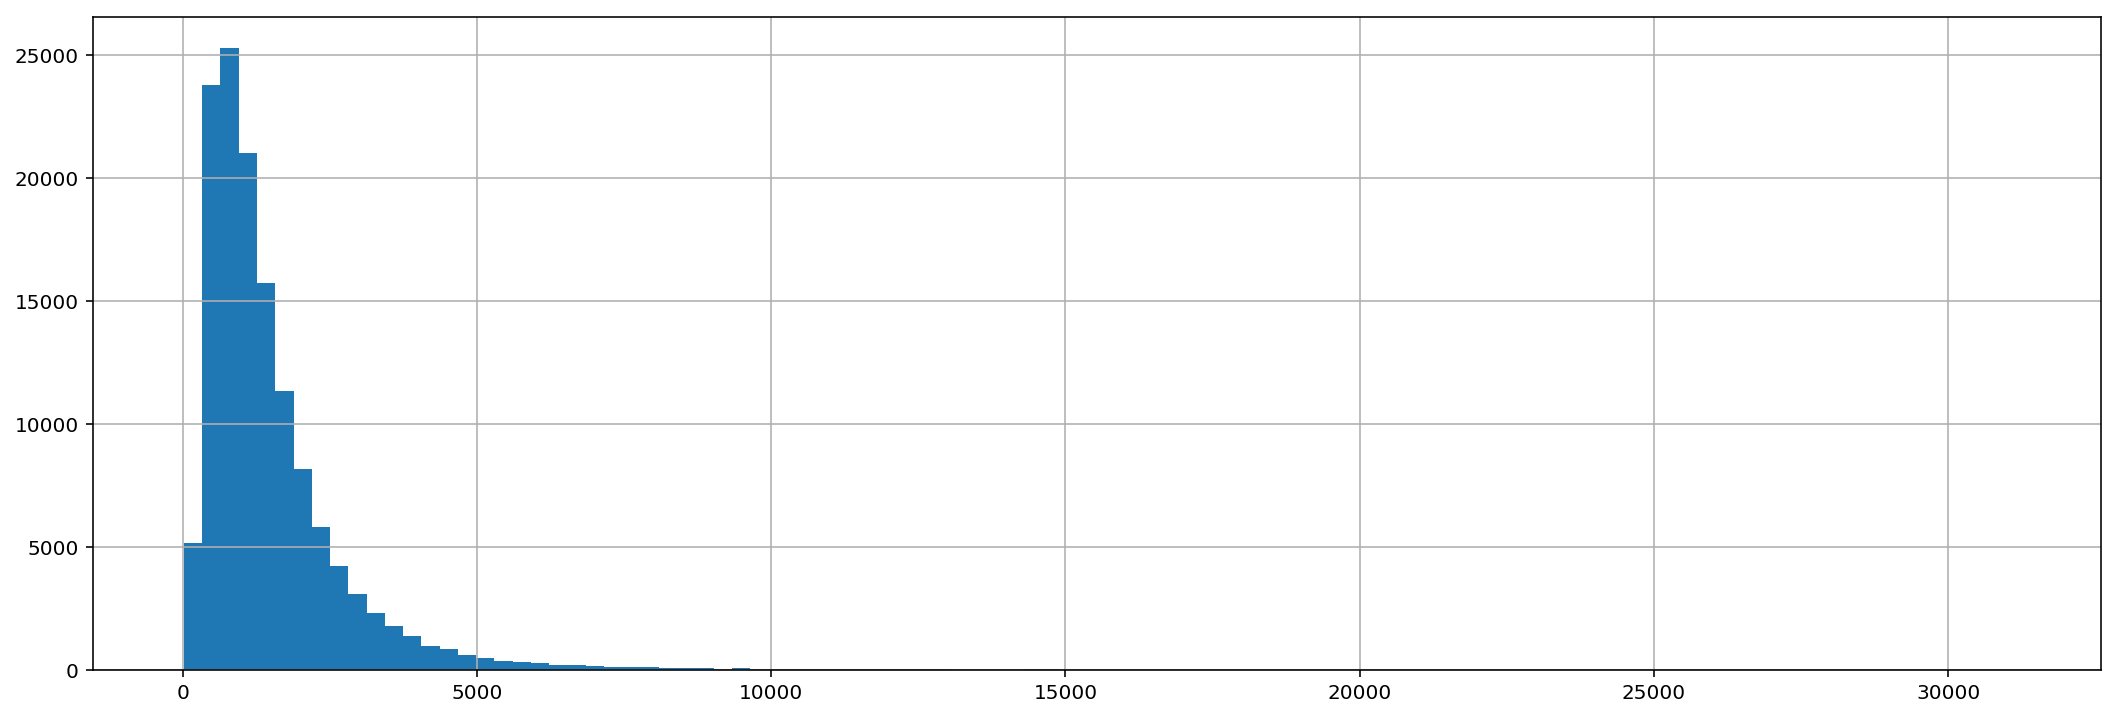

In [25]:
# text symbols hist
data.loc[:,'text'].str.len().hist(bins = 100,figsize = (18,6))

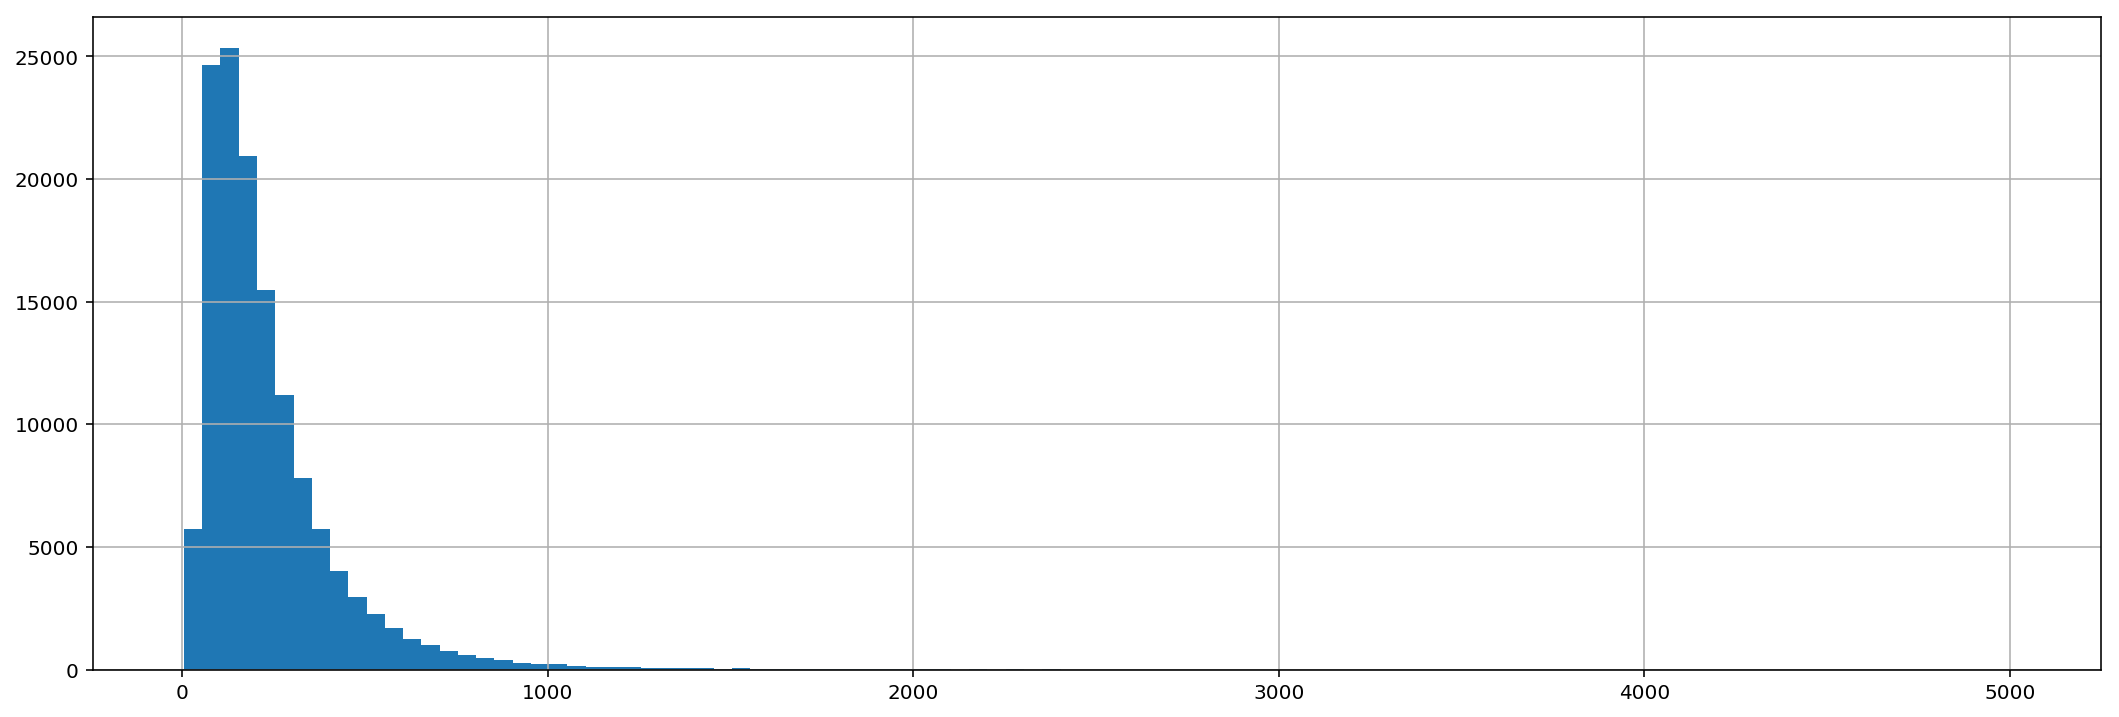

In [26]:
# text words hist
data.loc[:,'text'].str.split().str.len().hist(bins = 100,figsize = (18,6))

### 3. Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм 

In [27]:
from collections import Counter
from tqdm import tqdm_notebook as tqdm

In [28]:
cnt_words = Counter()
for word in tqdm(data.loc[:,'text'].str.split()):
    cnt_words.update(word)

In [29]:
# 10 самых частых слов без стоп слов
cnt_words.most_common(10)

[('в', 1176656),
 ('и', 934987),
 ('не', 755800),
 ('на', 626713),
 ('что', 567462),
 ('я', 513673),
 ('с', 411352),
 ('по', 333201),
 ('мне', 286709),
 ('банка', 248679)]

In [30]:
from nltk.corpus import stopwords

In [31]:
mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д','г']
def  remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

In [155]:
data['text'] = data['text'].apply(remove_stopwords)

In [33]:
cnt_words_1 = Counter()
for word in tqdm(data.loc[:,'text'].str.split()):
    cnt_words_1.update(word)

In [34]:
# 10 самых частых слов
cnt_words_1.most_common(10)

[('банка', 248679),
 ('банк', 192902),
 ('деньги', 116093),
 ('карту', 95233),
 ('карты', 92914),
 ('кредит', 70225),
 ('день', 68496),
 ('заявление', 63998),
 ('банке', 63701),
 ('отделение', 59231)]

Попробуем использовать mystem в terminale

In [ ]:
#np.savetxt(r'np.txt', data.loc[:,'text'].values, fmt='%s')

In [35]:
mystem_text = pd.read_csv('output.txt', sep=" ,", header=None)

/Users/maxim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [36]:
mystem_text.columns=['text']

In [37]:
mystem_text['text'] = mystem_text['text'].apply(words_only)

In [38]:
mystem_text['text'] = mystem_text['text'].apply(remove_stopwords)

In [39]:
mystoplemmas = ['который','прошлый','сей', 'свой', 'наш', 'мочь','девать','банка','карт','крайн']
def  remove_stoplemmas(text, mystoplemmas = mystoplemmas):
    try:
        return " ".join([token for token in text.split() if not token in mystoplemmas])
    except:
        return ""

In [40]:
mystem_text['text'] = mystem_text['text'].apply(remove_stoplemmas)

In [41]:
cnt_lemms = Counter()
for word in tqdm(mystem_text.loc[:,'text'].str.split()):
    cnt_lemms.update(word)

In [42]:
# 10 самых частых лемм
cnt_lemms.most_common(10)

[('банк', 597870),
 ('карта', 302971),
 ('весь', 244286),
 ('мень', 167644),
 ('деньги', 158845),
 ('день', 154642),
 ('давать', 139110),
 ('кредит', 136243),
 ('отделение', 126915),
 ('счет', 126032)]

### 4. существительных

In [43]:
from pymorphy2 import MorphAnalyzer

In [44]:
pm2 = MorphAnalyzer()

In [45]:
pm2.parse('банк')[0].tag

OpencorporaTag('NOUN,inan,masc sing,nomn')

In [46]:
lemmas_dict = dict(cnt_lemms.most_common())

In [47]:
lemmas_noun = [word for word in lemmas_dict.keys() if {'NOUN'} in pm2.parse(word)[0].tag]

In [48]:
cnt_lemmas_noun = {}
for word in lemmas_noun:
    cnt_lemmas_noun[word] = lemmas_dict[word]

In [49]:
# 10 самых частых существительных
Counter(cnt_lemmas_noun).most_common(10)

[('банк', 597870),
 ('карта', 302971),
 ('мень', 167644),
 ('деньги', 158845),
 ('день', 154642),
 ('кредит', 136243),
 ('отделение', 126915),
 ('счет', 126032),
 ('сотрудник', 121983),
 ('деньга', 121811)]

### Постройте кривые Ципфа и Хипса


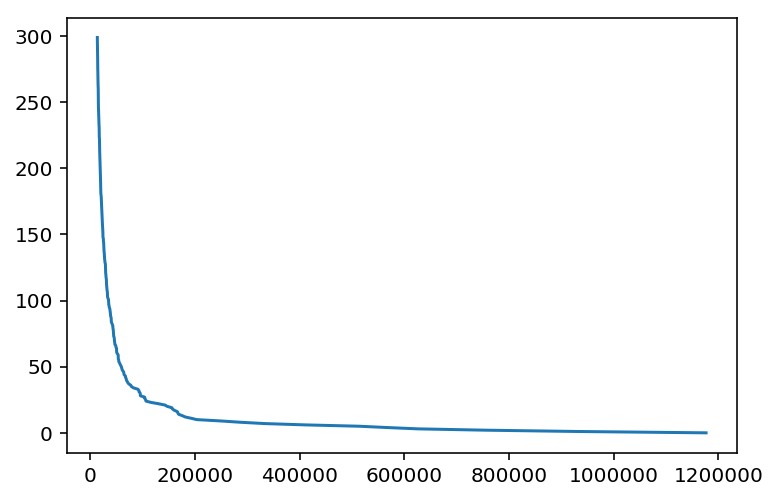

In [50]:
#Закон Ципфа
freqs = list(cnt_words.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.show()

In [105]:
#Закон Хипса

In [123]:
texts = mystem_text['text'].str.split()

In [124]:
n_tokens = np.cumsum(texts.apply(len))

In [115]:
cnt = Counter()
n_types = []
for index, row in tqdm(mystem_text.iterrows(), total = len(mystem_text)):
    tokens = row['text'].split()
    cnt.update(tokens)
    n_types.append(len(cnt))

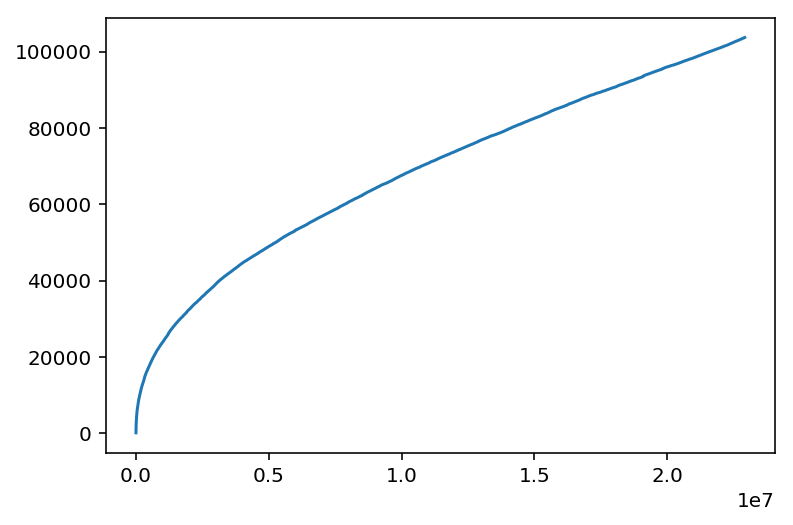

In [125]:
fig, ax = plt.subplots()
ax.plot(n_tokens, n_types)
plt.show()

какое слово встречается чаще, "сотрудник" или "клиент"?
сколько раз встречается слова "мошенничество" и "доверие"?

In [136]:
print(f'''слово "сотрудник" встречается ----> {cnt_lemms['сотрудник']} раз\n
слово "клиент" встречается   ---->  {cnt_lemms['клиент']} раз''')

слово "сотрудник" встречается ----> 121983 раз

слово "клиент" встречается   ---->  121049 раз


Ответ - сотрудник

In [139]:
print(f'''слово "мошенничество" встречается ----> {cnt_lemms['мошенничество']} раз\n
слово "доверие" встречается   ---->  {cnt_lemms['доверие']} раз''')

слово "мошенничество" встречается ----> 3015 раз

слово "доверие" встречается   ---->  1861 раз


В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру  𝑡𝑓−𝑖𝑑𝑓
t
f
−
i
d
f
 , для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

возьмем 1000 строк

In [51]:
def lemmatize(text, mystem=pm2):
    try:
        return ' '.join([pm2.parse(word)[0].normal_form for word in text.split()])
    except:
        return " "

In [52]:
rating_1 = data[data['rating_grade']==1].sample(1000)
rating_5 = data[data['rating_grade']==5].sample(1000)

In [63]:
rating_1['text_lemmas'] = rating_1['text'].apply(lemmatize)

In [64]:
rating_5['text_lemmas'] = rating_5['text'].apply(lemmatize)

In [72]:
rating_1_tokens = []
rating_5_tokens = []

In [73]:
for word in rating_1['text_lemmas']:
    rating_1_tokens += word.split()
for word in rating_5['text_lemmas']:
    rating_5_tokens += word.split()

In [77]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [80]:
def to_tfidf(tokens_list, n_min = 1, n_max = 1):
    tfidf = TfidfVectorizer(analyzer='word', ngram_range=(n_min, n_max), min_df = 0)
    tfidf_matrix =  tfidf.fit_transform([' '.join(tokens_list)])
    feature_names = tfidf.get_feature_names() 
    tfidf_ranking = []
    dense = tfidf_matrix.todense()

    text = dense.tolist()[0]
    phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
    sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
    phrases = []
    for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:40]:
        tfidf_ranking.append(phrase)
    return tfidf_ranking

In [82]:
rankings_1 = pd.DataFrame({'tf-idf': to_tfidf(rating_1_tokens)})
rankings_1.head(10)

,tf-idf
0,банка
1,карта
2,банк
3,деньга
4,день
5,отделение
6,мой
7,сотрудник
8,который
9,кредит


In [83]:
rankings_1 = pd.DataFrame({'tf-idf': to_tfidf(rating_1_tokens,2,2)})
rankings_1.head(10)

,tf-idf
0,сотрудник банка
1,написать заявление
2,денежный средство
3,кредитный карта
4,отделение банка
5,горячий линия
6,колл центр
7,рабочий день
8,сей пора
9,служба поддержка


In [84]:
rankings_5 = pd.DataFrame({'tf-idf': to_tfidf(rating_5_tokens)})
rankings_5.head(10)

,tf-idf
0,банка
1,банк
2,карта
3,очень
4,клиент
5,сотрудник
6,день
7,вклад
8,который
9,мой


In [85]:
rankings_5 = pd.DataFrame({'tf-idf': to_tfidf(rating_5_tokens,2,2)})
rankings_5.head(10)

,tf-idf
0,сотрудник банка
1,кредитный карта
2,интернет банк
3,клиент банка
4,другой банка
5,отделение банка
6,следующий день
7,являться клиент
8,интернет банка
9,дебетовый карта


## Часть 2. Тематическое моделирование [20/100]

1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

Эта часть задания может быть сделана с использованием gensim. 

 возьмем сэмпл из 10000

In [88]:
data_sample = data.sample(1000)

In [92]:
data['lemmas'] = data['text'].apply(lemmatize)

In [94]:
data.head(1)

,author,bank_license,bank_name,city,datetime,num_comments,rating_grade,rating_not_checked,text,title,lemmas
0,uhnov1,лицензия № 2562,Бинбанк,г. Москва,2015-06-08 12:50:54,0,NONE,False,добрый день являюсь клиентом банка поручителем...,Жалоба,добрый день являться клиент банка поручитель к...


In [116]:
titles = data['title'].value_counts()[1:7].index.tolist()

In [117]:
titles

['Претензия',
 'Кредитная карта',
 'Жалоба',
 'Благодарность',
 'Звонки из банка',
 'Банкомат съел деньги']

In [119]:
data = data[data['title'].isin(titles)]

In [120]:
from gensim.corpora import *
texts = [data.lemmas.iloc[i].split() for i in range(len(data))]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [122]:
from gensim.models import  *
from gensim import similarities

tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

index = similarities.MatrixSimilarity(corpus_tfidf)
sims = index[corpus_tfidf]

In [130]:
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=6)

In [136]:
lsi.show_topics()

[(0,
  '0.189*"карта" + 0.147*"банкомат" + 0.141*"деньга" + 0.117*"кредит" + 0.115*"ваш" + 0.115*"номер" + 0.111*"рубль" + 0.106*"звонок" + 0.104*"заявление" + 0.104*"сумма"'),
 (1,
  '0.388*"банкомат" + 0.253*"деньга" + -0.205*"звонок" + -0.198*"номер" + -0.174*"ваш" + -0.146*"телефон" + 0.129*"карта" + -0.120*"звонить" + -0.117*"поступать" + 0.115*"купюра"'),
 (2,
  '0.389*"банкомат" + 0.233*"номер" + -0.221*"карта" + 0.188*"деньга" + -0.163*"кредитный" + 0.146*"звонок" + -0.132*"платёж" + 0.127*"купюра" + 0.121*"телефон" + 0.101*"база"'),
 (3,
  '-0.211*"платёж" + -0.200*"рубль" + -0.198*"сумма" + -0.166*"задолженность" + 0.157*"благодарность" + -0.145*"договор" + 0.129*"очень" + 0.125*"вклад" + 0.119*"заявка" + 0.114*"выразить"'),
 (4,
  '-0.247*"карта" + -0.166*"звонить" + 0.139*"средство" + 0.135*"денежный" + -0.131*"номер" + 0.130*"рф" + 0.128*"договор" + -0.124*"заявка" + 0.121*"благодарность" + -0.117*"неделя"'),
 (5,
  '-0.318*"карта" + 0.226*"платёж" + -0.180*"персональный" 

In [ ]:
3 - благодарность, 0-звонки из банка. Темы очень похожие получились в целом

In [135]:
lda = ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=6,
                        alpha='auto', eta='auto', iterations = 20, passes = 5)

In [137]:
lda.show_topics(6)

[(0,
  '0.030*"банка" + 0.014*"сотрудник" + 0.012*"банк" + 0.010*"клиент" + 0.010*"карта" + 0.009*"ваш" + 0.008*"который" + 0.008*"мой" + 0.007*"звонок" + 0.007*"год"'),
 (1,
  '0.017*"банка" + 0.015*"карта" + 0.014*"банк" + 0.010*"мой" + 0.009*"счёт" + 0.009*"кредитный" + 0.009*"претензия" + 0.008*"сотрудник" + 0.008*"отделение" + 0.008*"задолженность"'),
 (2,
  '0.025*"деньга" + 0.019*"банкомат" + 0.018*"карта" + 0.012*"банка" + 0.011*"счёт" + 0.011*"день" + 0.010*"мой" + 0.009*"сказать" + 0.008*"заявление" + 0.007*"сбербанк"'),
 (3,
  '0.009*"банка" + 0.008*"карта" + 0.008*"сотрудник" + 0.007*"мой" + 0.007*"день" + 0.006*"банк" + 0.006*"деньга" + 0.006*"отделение" + 0.006*"дать" + 0.005*"который"'),
 (4,
  '0.025*"банка" + 0.015*"номер" + 0.015*"звонок" + 0.014*"ваш" + 0.013*"телефон" + 0.013*"мой" + 0.013*"кредит" + 0.012*"банк" + 0.011*"звонить" + 0.010*"сотрудник"'),
 (5,
  '0.023*"карта" + 0.017*"банка" + 0.016*"кредит" + 0.011*"кредитный" + 0.011*"рубль" + 0.011*"банк" + 0.010*

In [ ]:
LDA получше описывает темы. 1 -претензия, 2 - жалоба (Был клиентом сбернка, теперь как слышу, так ассоциации с жалобой :))

In [138]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis
vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

/Users/maxim/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


## Часть 3. Классификация текстов [40/100]

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5). 

1.  Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте ```sklearn.model_selection.train_test_split``` для разделения множества отобранных документов на обучающее и тестовое. 
2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам. 
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
* 1-ый вариант: $tf-idf$ преобразование (```sklearn.feature_extraction.text.TfidfTransformer```) и сингулярное разложение (оно же – латентый семантический анализ) (```sklearn.decomposition.TruncatedSVD```), 
* 2-ой вариант: тематические модели LDA (```sklearn.decomposition.LatentDirichletAllocation```). 

Используйте accuracy и F-measure для оценки качества классификации. 

Ниже написан примерный Pipeline для классификации текстов. 

Эта часть задания может быть сделана с использованием sklearn. 

In [225]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import LatentDirichletAllocation

In [186]:
df = data.copy()

In [187]:
df = df[(df['rating_grade']==1) | (df['rating_grade']==5)]

In [190]:
df.rating_grade.value_counts()

1.0    38661
5.0    10227
Name: rating_grade, dtype: int64

In [188]:
df_5 = df[df['rating_grade']==5]
len(df_5)

10227

In [189]:
df_1 = df[df['rating_grade']==1].iloc[:10227]

In [191]:
len(df_1)

10227

In [192]:
df_1_5 = pd.concat([df_1, df_5])

In [193]:
df_1_5 = df_1_5.loc[:,['bank_name','text','rating_grade']]

In [197]:
%time
df_1_5['text'] = df_1_5['text'].apply(lemmatize) 
df_1_5['text'] = df_1_5['text'].apply(remove_stoplemmas)  

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs


In [200]:
# 1 -5 rating, 0 -1 rating
df_1_5['rating_grade'] = df_1_5['rating_grade'].map({5:1,1:0})

In [232]:
#df_1_5.drop(columns='bank_name',inplace=True)

In [233]:
df_full= df_1_5.copy()

In [234]:
y = df_full['rating_grade']

In [235]:
X = df_full.drop(columns='rating_grade')

In [261]:
X.shape,y.shape

((20454, 1), (20454,))

In [249]:
count_vect = CountVectorizer()

In [263]:
X_counts = count_vect.fit_transform(X['text']).toarray()

In [265]:
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)

In [267]:
#tm = TruncatedSVD()

In [268]:
#X_tm = tm.fit_transform(X_tfidf)

In [299]:
X = pd.DataFrame(X_tfidf.toarray())

In [300]:
X.shape,y.shape

((20454, 39852), (20454,))

In [244]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

In [301]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [280]:
forest_params = {
    'n_estimators': [5, 10, 20, 40],
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 3, 5, 7, 9, None],
    'min_samples_leaf': [1, 2, 4, 8, 16]
}

In [281]:
forest = RandomForestClassifier()

In [282]:
grid_forest = GridSearchCV(forest, forest_params, scoring='accuracy', cv = 5, n_jobs=-1)

In [283]:
grid_forest.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [284]:
grid_forest.best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'min_samples_leaf': 2,
 'n_estimators': 10}

In [302]:
forest_grid = RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_leaf=2, n_estimators=10)

In [303]:
forest_grid.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [304]:
y_train_predict = forest_grid.predict(X_train)
y_test_predict = forest_grid.predict(X_test)

In [305]:
accuracy_score(y_test, y_test_predict)

0.7804937668051821

In [306]:
f1_score(y_test, y_test_predict)

0.773346794548208

In [307]:
clf = xgboost.XGBClassifier(
                    max_depth=5,
                    n_jobs=-1,
                    n_estimators=101,
                    min_samples_split=200,
                    learning_rate=0.079,
                    max_features='log2',
                    )

In [308]:
clf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.079,
              max_delta_step=0, max_depth=5, max_features='log2',
              min_child_weight=1, min_samples_split=200, missing=None,
              n_estimators=101, n_jobs=-1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
              subsample=1)

In [309]:
y_train_predict = clf.predict(X_train)
y_test_predict = clf.predict(X_test)

In [310]:
accuracy_score(y_test, y_test_predict)

0.9195795648985579

In [311]:
f1_score(y_test, y_test_predict)

0.9172743273824491

In [ ]:
#XGBClassifier показал результат значительно лучше, чем RandomForestClassifier()
# но обучался XGBClassifier гораздо больше по времени